In [1]:
import pandas as pd
import yaml
import os
import sys
import numpy as np
import glob 
import pickle
sys.path.append('./../../')
sys.path.append('./..')
import inspect
import matplotlib.pyplot as plt
import sys
import time
import yaml
import time
from collections import OrderedDict

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc
import glob

In [2]:
from src.ape import tf_model_ape_1
from src.data_fetcher import data_fetcher


/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/s

/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ddatta/anaconda3/envs/AD_v2/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ddatta/anaconda3/envs/

In [3]:
CONFIG = None
OP_DIR = None
DATA_DIR = None
domain_dims = None
SAVE_DIR = None
CONFIG_FILE = 'config_1.yaml'
domain_dims = None

# ------------------------------------- #
def get_domain_dims(dd_file_path):
    with open(dd_file_path, 'rb') as fh:
        domain_dims = pickle.load(fh)
    _tmpDF = pd.DataFrame.from_dict(domain_dims, orient='index')
    _tmpDF = _tmpDF.reset_index()
    _tmpDF = _tmpDF.rename(columns={'index': 'domain'})
    _tmpDF = _tmpDF.sort_values(by=['domain'])
    res = {k: v for k, v in zip(_tmpDF['domain'], _tmpDF[0])}
    return res
# ------------------------------------- #
# Set up config & global vars
# ------------------------------------- #
def setup():
    global SAVE_DIR
    global DIR
    global CONFIG
    global OP_DIR
    global DATA_DIR
    global domain_dims
   
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)
  
    SAVE_DIR = CONFIG['SAVE_DIR']
    DIR = CONFIG['DIR']
        
    OP_DIR = CONFIG['OP_DIR']
    DATA_DIR = CONFIG['DATA_DIR']
    
    if not os.path.exists(SAVE_DIR):
        os.mkdir(SAVE_DIR)
    SAVE_DIR = os.path.join(SAVE_DIR, DIR)
 
    if not os.path.exists(SAVE_DIR):
        os.mkdir(SAVE_DIR)

    if not os.path.exists(OP_DIR):
        os.mkdir(OP_DIR)

    OP_DIR = os.path.join(OP_DIR, DIR)
    if not os.path.exists(OP_DIR):
        os.mkdir(OP_DIR)
        
    tf_model_ape_1._DIR = DIR
    tf_model_ape_1.OP_DIR = OP_DIR
    if not os.path.exists(OP_DIR):
        os.mkdir(OP_DIR)
        
    
    dd_file_path = os.path.join(DATA_DIR, DIR, 'domain_dims.pkl')
    domain_dims = get_domain_dims(dd_file_path)
 
    print('DATA_DIR : ' ,DATA_DIR)
    print('OP_DIR :', OP_DIR)
    print('SAVE_DIR :', SAVE_DIR)
    
setup()

DATA_DIR :  ../../generated_data_v1
OP_DIR : output/us_import1
SAVE_DIR : save_dir/us_import1


## --------------------------------- 

This function gets the testing data
Set :
1. Anomaly percentage to be 20 % of data: So 1:4 ratio
2. Why type 2 ? : Clusters
3. what are the configs ? 'test_anomaly_perc'

## ----------------------------------


In [22]:
def get_testing_data(anomaly_type = 1):
    global DIR
    global DATA_DIR
    global CONFIG
    
    p =  int(CONFIG['test_anomaly_perc'])
    _, _, _, _, test_x ,test_idList, anomaly_x, anomaly_idList = data_fetcher.get_data_APE(
        DATA_DIR,
        DIR,
        anomaly_type
    )
    print(len(anomaly_idList))
    print(len(test_idList))
    reqd_anom_count = int(p/(100-p) * len(test_idList))
    
    anomaly_idList = anomaly_idList[:reqd_anom_count]
    anomaly_x = anomaly_x[:reqd_anom_count]
    
    return  test_x ,test_idList, anomaly_idList, anomaly_x
    

In [35]:

def run_APE():
    global DIR
    global OP_DIR
    global SAVE_DIR
    global DATA_DIR
    global CONFIG
    global domain_dims
    MODEL_NAME = 'model_APE'
    
    # ------------ #
    
    checkpoint_dir = os.path.join(SAVE_DIR,'checkpoints')
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

    _DATA_DIR = CONFIG['DATA_DIR']
    train_x_pos, train_x_neg, APE_term_2, APE_term_4, _, _,  _,_ = data_fetcher.get_data_APE(
        _DATA_DIR,
        DIR
    )
    
    print(train_x_pos.shape, train_x_neg.shape, APE_term_2.shape, APE_term_4.shape)
    
    neg_samples = train_x_neg.shape[1]
    start_time = time.time()
    num_domains = len(domain_dims)
    inp_dims = list(domain_dims.values())

    print('Number of domains ', num_domains )
    print(' domains ', inp_dims)
    ape_model_obj = tf_model_ape_1.model_ape_1(MODEL_NAME)
    
    ape_model_obj.set_model_params(
        num_entities = num_domains,
        inp_dims = inp_dims,
        neg_samples = neg_samples,
        batch_size = CONFIG[DIR]['ape_batchsize'],
        num_epochs = CONFIG[DIR]['ape_num_epochs'],
        lr = CONFIG[DIR]['ape_learning_rate'],
        chkpt_dir = checkpoint_dir
    )

    _emb_size = int(CONFIG[DIR]['ape_embed_size'])
    ape_model_obj.set_hyper_parameters(
        emb_dims=[_emb_size],
        use_bias=[True, False]
    )

    _use_pretrained = CONFIG[DIR]['ape_use_pretrained']

    if _use_pretrained is False:
        print(' Building and training model ')
        ape_model_obj.build_model()
        ape_model_obj.train_model(
            train_x_pos,
            train_x_neg,
            APE_term_2,
            APE_term_4
        )

    test_x ,test_idList, anomaly_idList, anomaly_x = get_testing_data(anomaly_type = 2)

    '''
    join the normal data + anomaly data
    join the normal data id +  anomaly data id 
    Maintain order
    '''
    
    test_normal_ids = test_idList
    test_anomaly_ids = anomaly_idList
    test_ids = list(np.hstack([test_normal_ids,test_anomaly_ids]))
    
    
    test_normal_data = test_x
    test_anomaly_data = anomaly_x
    test_data_x = np.vstack([
        test_normal_data,
        test_anomaly_data
    ])
    num_anomalies = len(anomaly_idList)
    print (' Length of Entire test set (with anomalies) :: ', len(test_ids), 'test x shape', test_data_x.shape )
    # ---------- #

    result_scores = ape_model_obj.inference(test_data_x)
    result_scores = list(result_scores)
    print(len(result_scores))
    assert len(test_ids) == len(result_scores), "Error!!"
    
    # --------------------------------- #
    # Create a dataframe to store results
    # --------------------------------- #
    result_df = pd.DataFrame(columns=['id','score','anomaly_flag'])
    result_df['id'] = test_ids
    result_df['score'] = result_scores
    
    def _check_id (val, test_anomaly_ids):
        if val in test_anomaly_ids:
            return 1
        else :
            return 0
        
    result_df['anomaly_flag'] = result_df['id'].apply(_check_id, args=(test_anomaly_ids,))
    result_df = result_df.sort_values(by = ['score'])
    


    # ---------------------------------- #
    # Investigate at k = 1000,2000,3000,4000,5000 what are the Precision and recall rates
    # -----------------------------------# 
    

    return result_df




In [36]:
result_df_ape = run_APE()

(140382, 8) (140382, 24, 8) (140382, 1) (140382, 24, 1)
Number of domains  8
 domains  [548, 5113, 95, 238, 64, 113, 116, 6193]
save_dir/us_import1/checkpoints/model_APE_12_k_24_frozen.pb
10843
25595
 Length of Entire test set (with anomalies) ::  28438 test x shape (28438, 8)
(28438, 8)
 number of batches .... 55
28438
28438


In [54]:
def analyze_and_plot(df, step = 250):
    _msg_ = ' Analyze how precision changes. Between k and (k+step) records ata the top'
    print('----')
    list_step = []
    list_prec = []
    
    num_anomalies = len(df.loc[df['anomaly_flag']==1])
    print(' Number of Anomalies :: ', num_anomalies )
    for k in range(250,num_anomalies+step,step):
        _tmp = df.head(k).tail(step)
        correct = len(_tmp.loc[_tmp['anomaly_flag']==1])
        prec = correct/len(_tmp)
        list_prec.append(prec)
        list_step.append(k)
    
    print('Step :: {} '.format(list_step)) 
    print('Precision :: {} '.format(list_prec))
    
     
    plt.figure(figsize=[10,10])
    plt.title(_msg_)
    plt.xlabel('Count')
    plt.ylabel('Precision')
    plt.plot(list_step,list_prec,'r-')
    plt.grid()
    plt.show()
    plt.close()
    

----
 Number of Anomalies ::  2843
Step :: [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000] 
Precision :: [0.952, 0.94, 0.868, 0.752, 0.756, 0.548, 0.492, 0.624, 0.508, 0.504, 0.46, 0.456] 


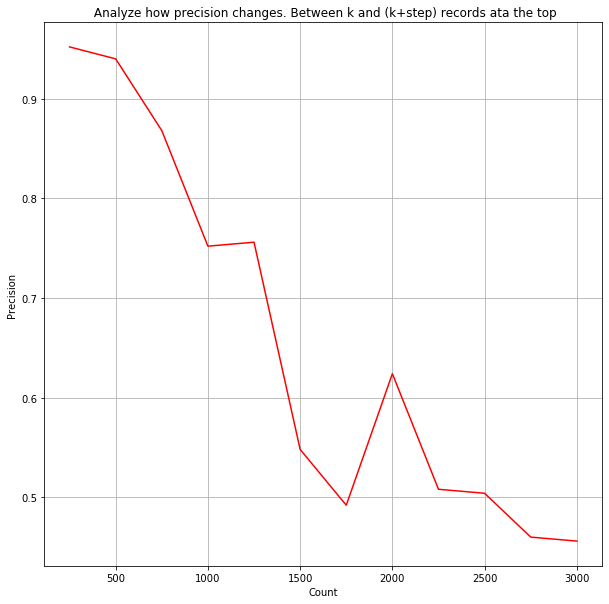

In [55]:
analyze_and_plot(result_df_ape)